In [1]:
import os
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%config InlineBackend.figure_formatrmat = 'retina'

In [2]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data
from stesml.data_tools import get_test_data

from stesml.model_tools import get_model
from stesml.model_tools import walk_forward_validation
from stesml.model_tools import get_predictions
from stesml.model_tools import get_progress

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error
from stesml.plot_tools import plot_progress_results

from stesml.postprocessing_tools import get_h
from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_Ac
from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_As

/Users/kmenear/Projects/envSulfurTES/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [4]:
model_type = "XGBoost"
is_recurrent = False
n_estimators = 100
target = 'h'
per_case = False
x = 0

In [6]:
train_index, test_index = get_train_and_test_index(scenario_index)

X_train, y_train = get_train_data(scenario_index, train_index, test_index, is_recurrent, target=target, per_case=per_case, x=x)
X_test, y_test = get_test_data(scenario_index, test_index, is_recurrent, target=target, x=x)

In [7]:
model = get_model(model_type, n_estimators)

In [8]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [9]:
y_hat = get_predictions(model, X_test, is_recurrent)

In [10]:
print(r2_score(y_test, y_hat))

0.994693252111637


In [11]:
print(mean_squared_error(y_test, y_hat, squared=False))

3.9957084782657892


In [13]:
test_df = load_data(scenario_index, test_index, x=x)

In [14]:
test_df["h_hat"] = y_hat

In [15]:
def get_T(T_prev, h, Tw, timestep):
    Ac = get_Ac()
    m = get_m(T_prev, Ac)
    Cp = get_Cp(T_prev)
    As = get_As()
    slope = ( h*As*(Tw - T_prev) )/( m*Cp )
    T = slope*timestep + T_prev
    return T

[400.         399.99999977 399.99999978 ... 413.18708447 413.18714346
 413.18720244]


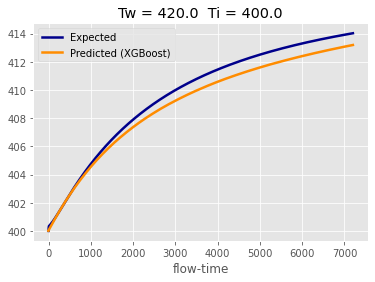

[400.         399.99999977 399.99999976 ... 436.7630759  436.76334836
 436.76362082]


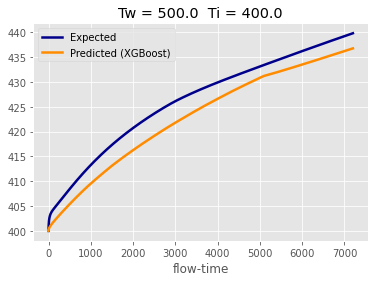

[440.         439.99999974 439.99999971 ... 484.94153025 484.94200143
 484.9424726 ]


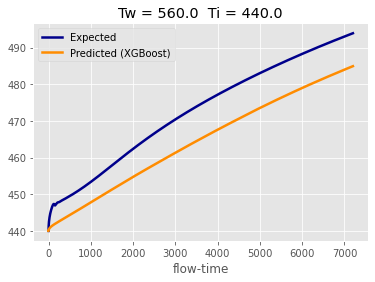

[460.         459.99999973 459.99999964 ... 498.53739673 498.53778792
 498.53817911]


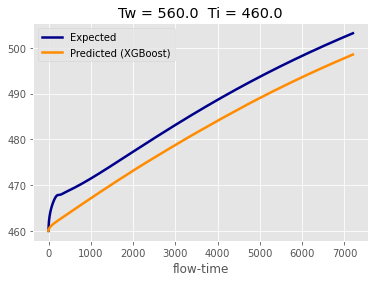

[440.         439.99999974 440.00000024 ... 516.6152701  516.61596551
 516.6166609 ]


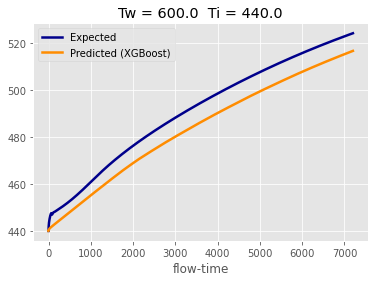

[400.         399.99999977 399.99999978 ... 516.6152701  516.61596551
 516.6166609 ]


In [16]:
T_hat = np.array([])
T_expected = np.array([])
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    T_hat_grp = np.array([])
    Ti = grp["Ti"][0]
    Tw = grp["Tw"][0]
    T_hat_grp = np.append(T_hat_grp, Ti)
    T_prev = Ti
    for i, h in enumerate(grp["h_hat"]):
        if i == len(grp["h_hat"]) - 1:
            continue
        if i < 1:
            T = grp["Tavg"][i]
            T_hat_grp = np.append(T_hat_grp, T)
            T_prev = T
            h_prev = h
            continue
        timestep = grp["flow-time"][i] - grp["flow-time"][i-1]
        T = get_T(T_prev, h_prev, Tw, timestep)
        T_hat_grp = np.append(T_hat_grp, T)
        T_prev = T
        h_prev = h
    print(T_hat_grp)
    # Plotting results
    grp["T_hat"] = T_hat_grp
    ax = grp.plot(x="flow-time", y='Tavg', c='DarkBlue', linewidth=2.5, label="Expected")
    plot = grp.plot(x="flow-time", y='T_hat', c='DarkOrange', linewidth=2.5, label="Predicted ({model_type})".format(model_type=model_type), ax=ax)
    plt.title('Tw = {Tw}  Ti = {Ti}'.format(Tw=idx[0], Ti=idx[1]))
    plt.show()
    T_hat = np.concatenate((T_hat, T_hat_grp))
    T_expected = np.concatenate((T_expected, grp["Tavg"]))
print(T_hat)

In [17]:
print(r2_score(T_expected, T_hat))

0.9752608546956429


In [18]:
print(mean_squared_error(T_expected, T_hat, squared=False))

5.63887898386921


In [19]:
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent, target=target)

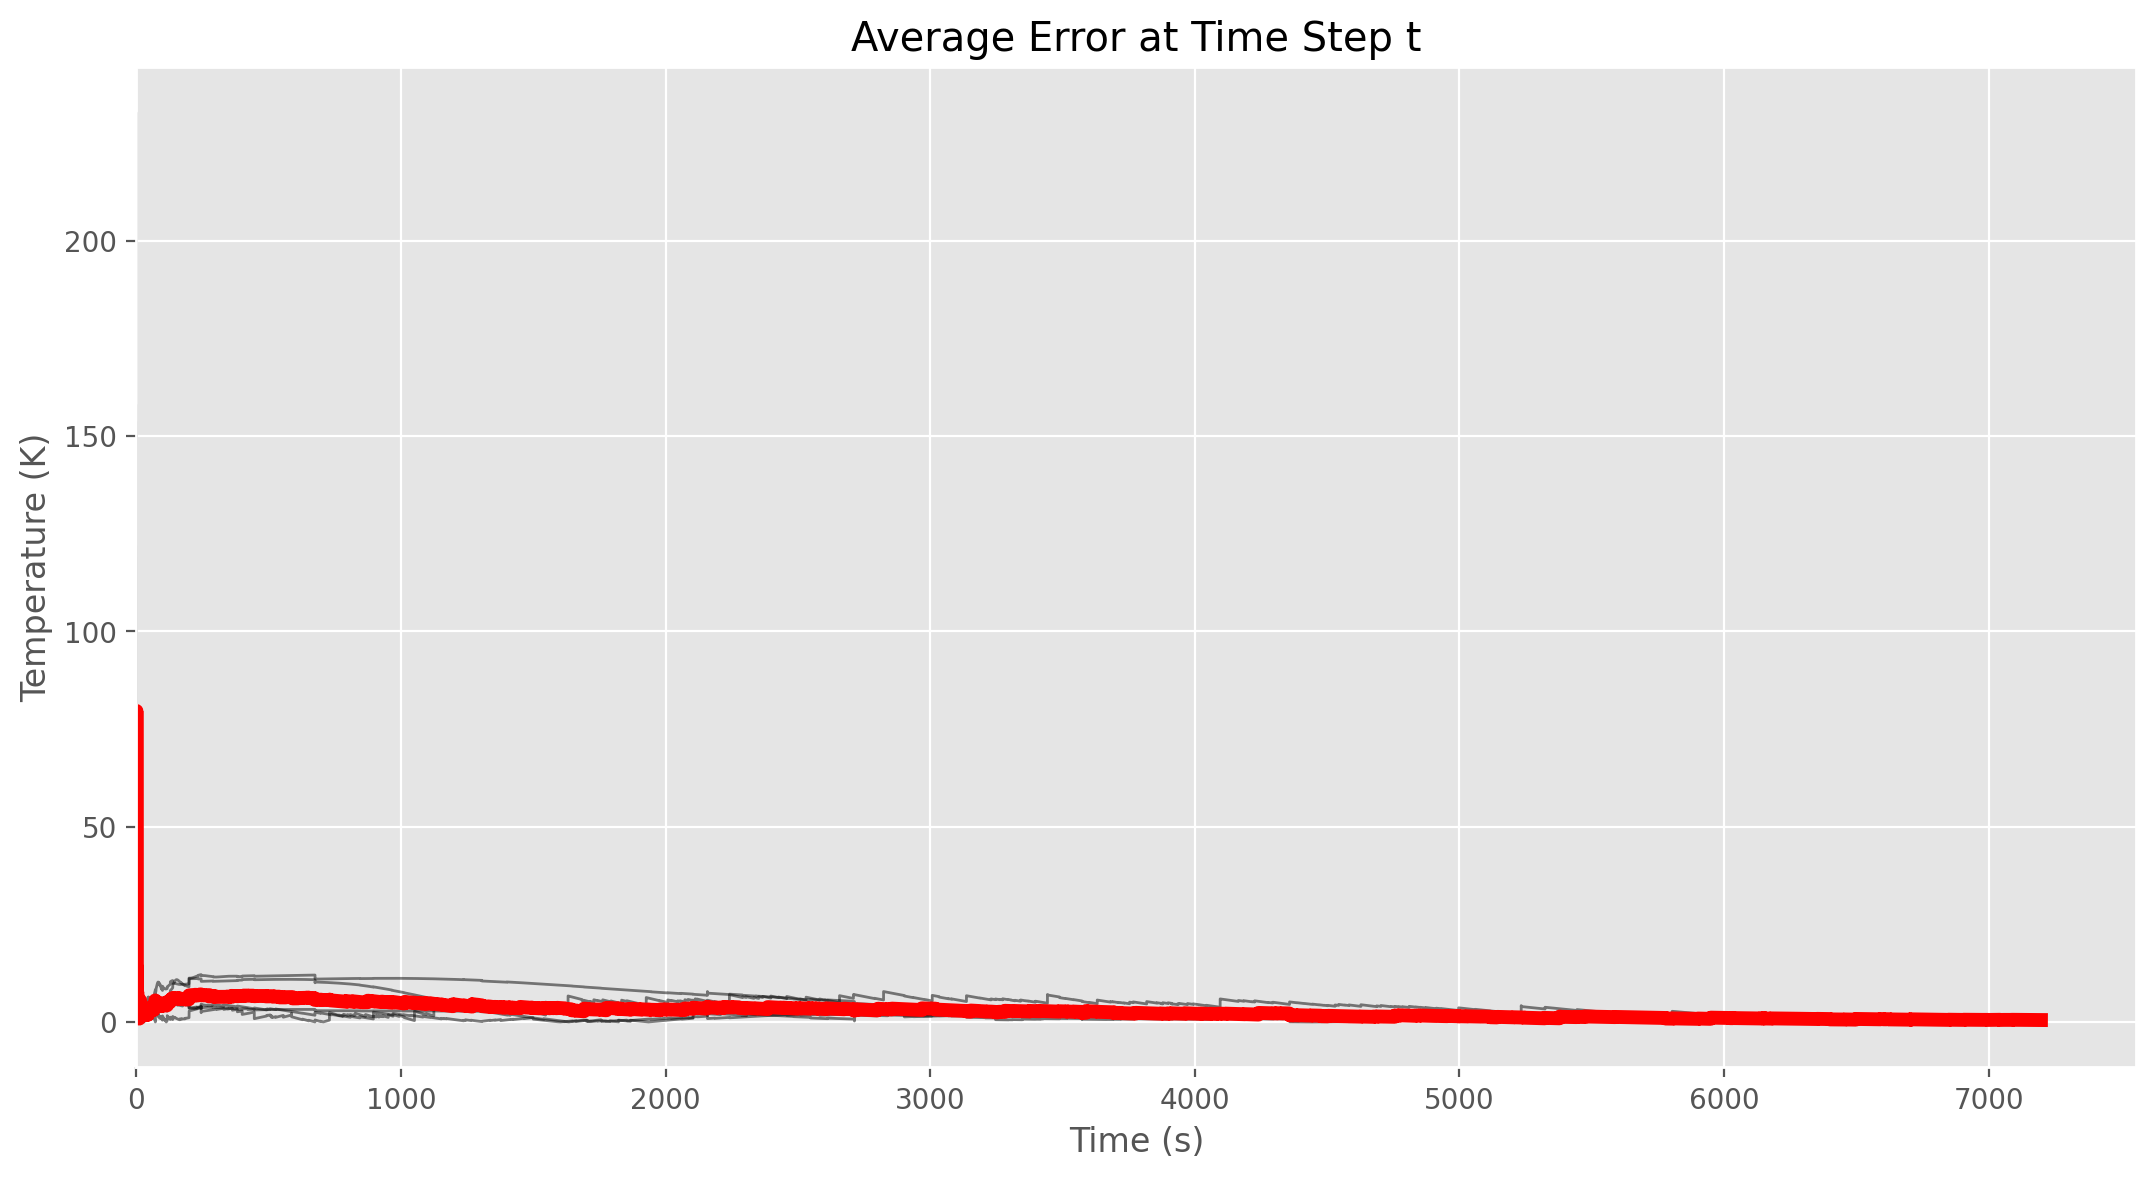

In [21]:
plot_average_error(test_df_plot, target=target)

<AxesSubplot:>

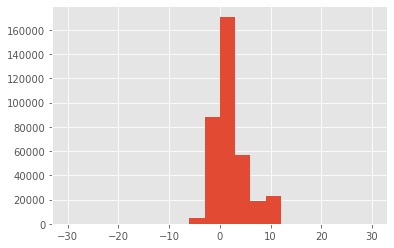

In [22]:
(test_df_plot[target] - test_df_plot[target+'_hat']).hist(bins=20, range=(-30, 30))

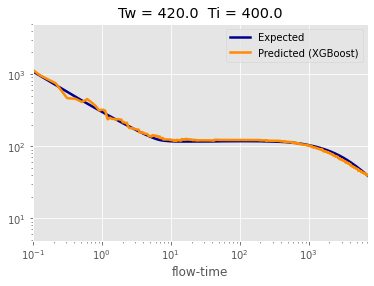

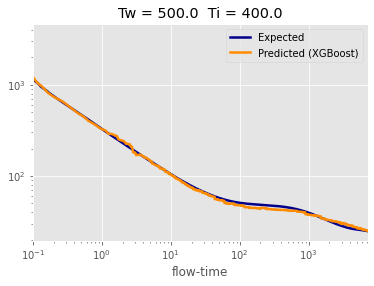

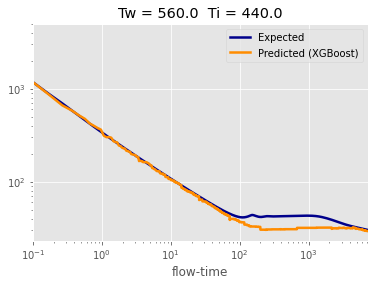

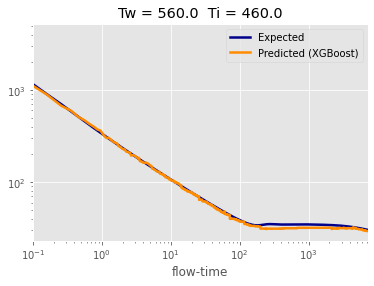

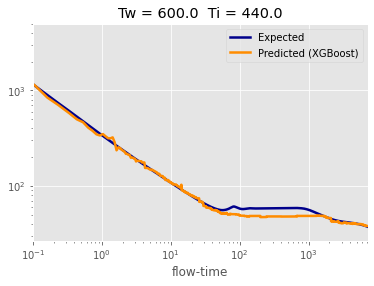

In [24]:
plot_test_results(test_df_plot, model_type, target=target)

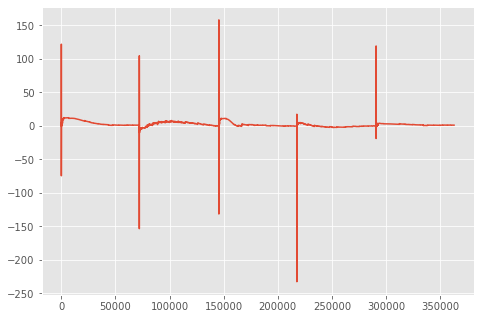

In [25]:
import matplotlib.pyplot as plt
ax = plt.figure().add_axes([0,0,1,1])
ax.plot(y_test-y_hat)
#ax.set_yscale('log')
plt.show()

In [26]:
min_estimators = 10
max_estimators = 11
step_size = 2
num_shuffle_iterations = 100

rmse_history, r2_history = get_progress(model_type, scenario_index, min_estimators, max_estimators, step_size, num_shuffle_iterations, is_recurrent, verbose=True, target=target, per_case=per_case, x=x)

0
Predicted: [  26.317245 3573.4807   3573.4807   ...   22.645817   22.645817
   22.645817]
Expected: [   0.         3668.86628447 3664.38943667 ...   25.05571994   25.0555973
   25.05548041]
1
Predicted: [ 270.16803  3850.9485   3850.9485   ...   38.086594   38.086594
   38.086594]
Expected: [   0.         4121.241794   4117.32856177 ...   37.36523361   37.3651047
   37.36507147]
2


KeyboardInterrupt: 

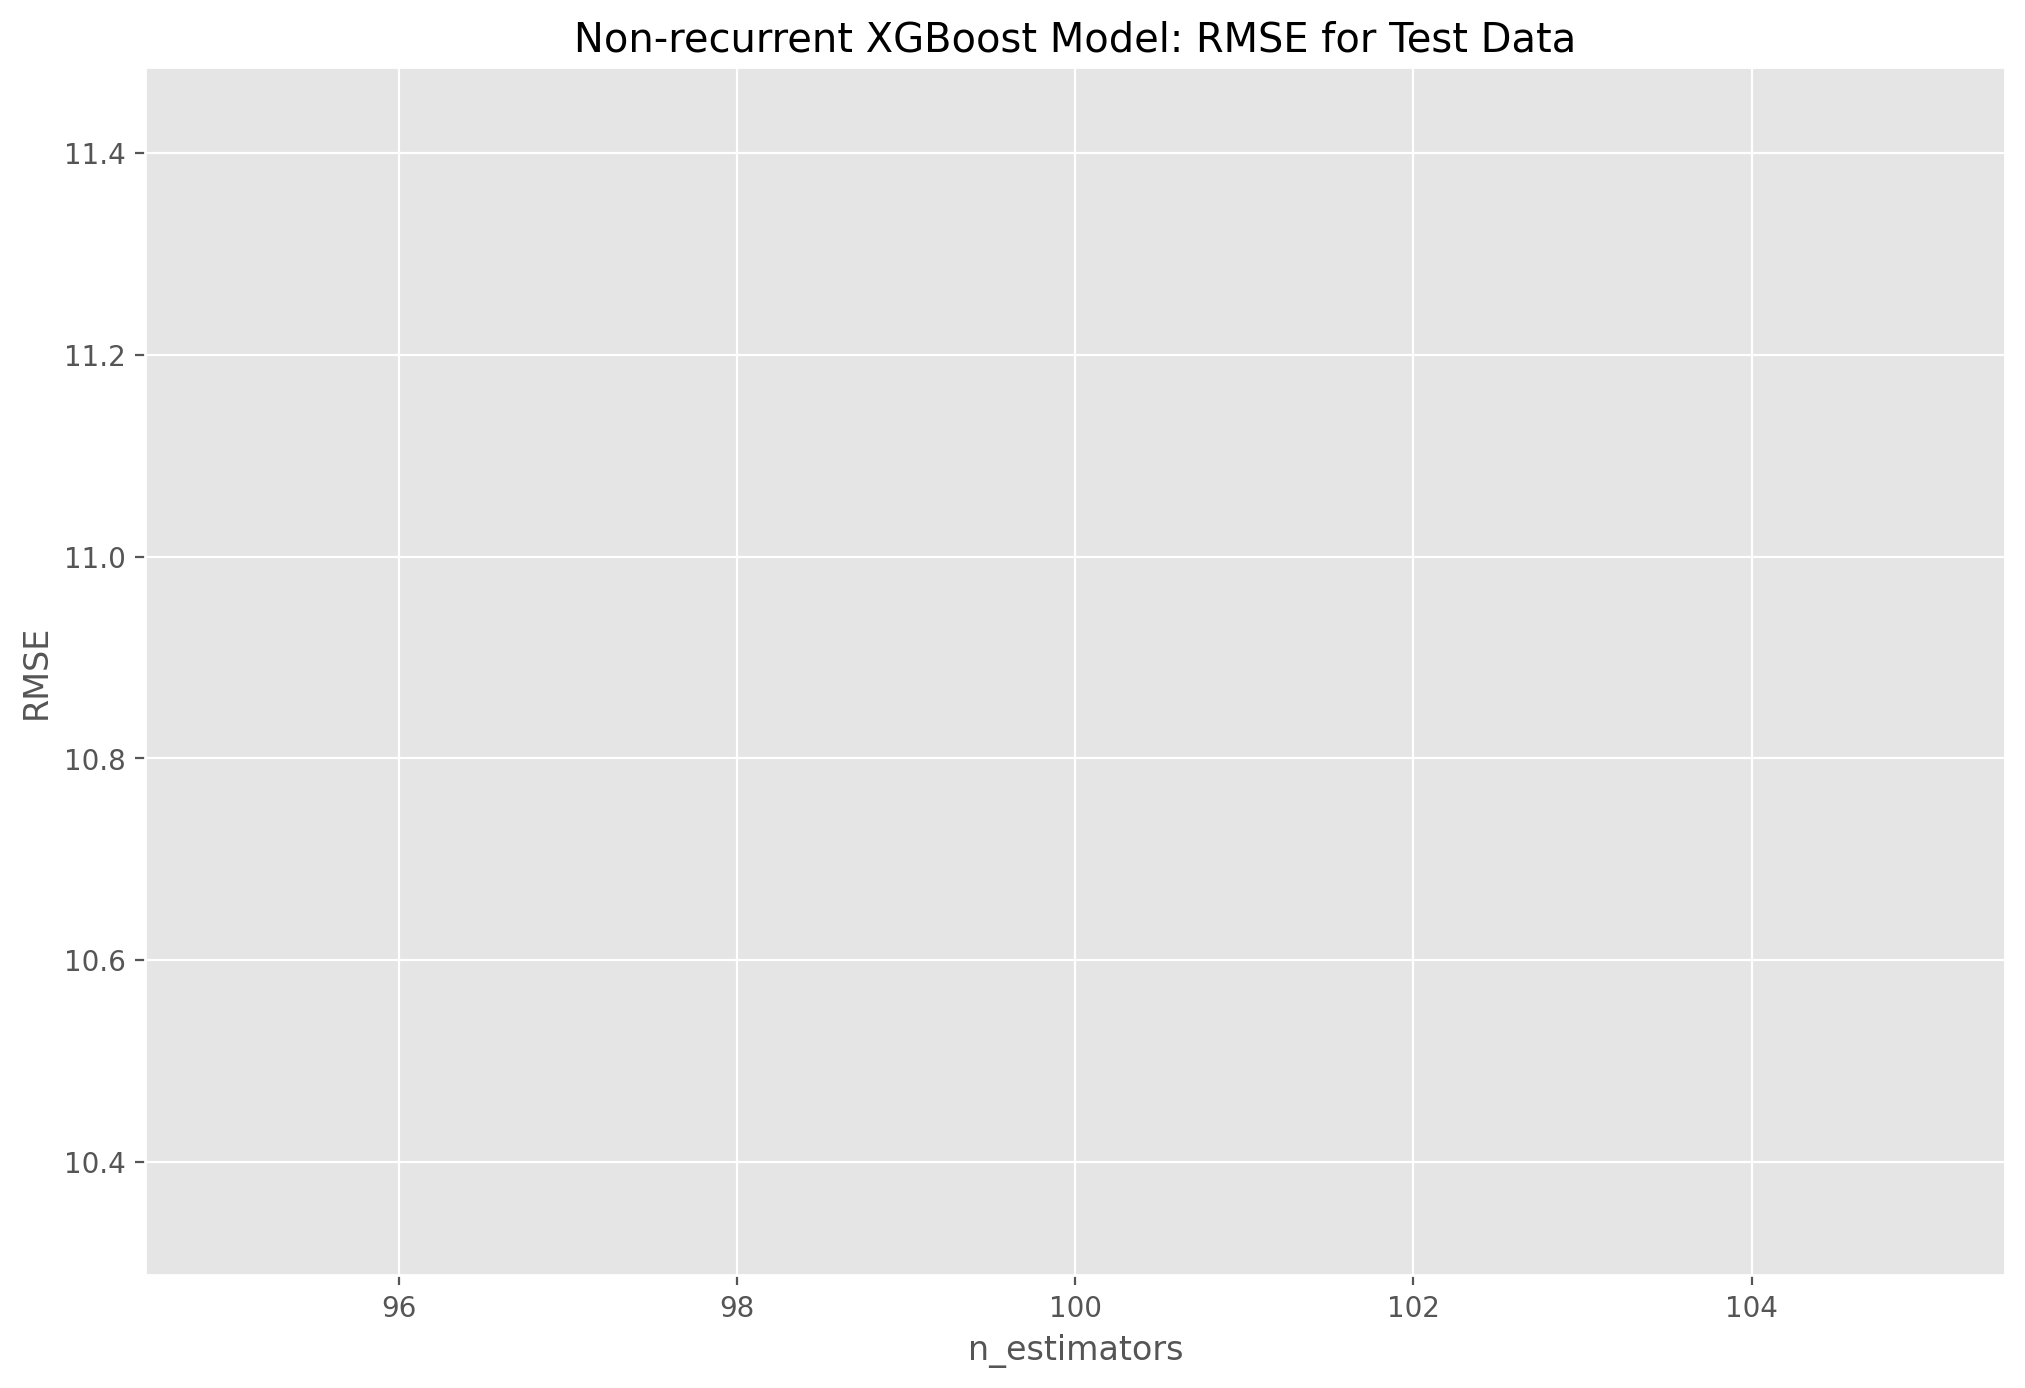

In [21]:
plot_progress_results(rmse_history, model_type, is_recurrent, metric="RMSE")

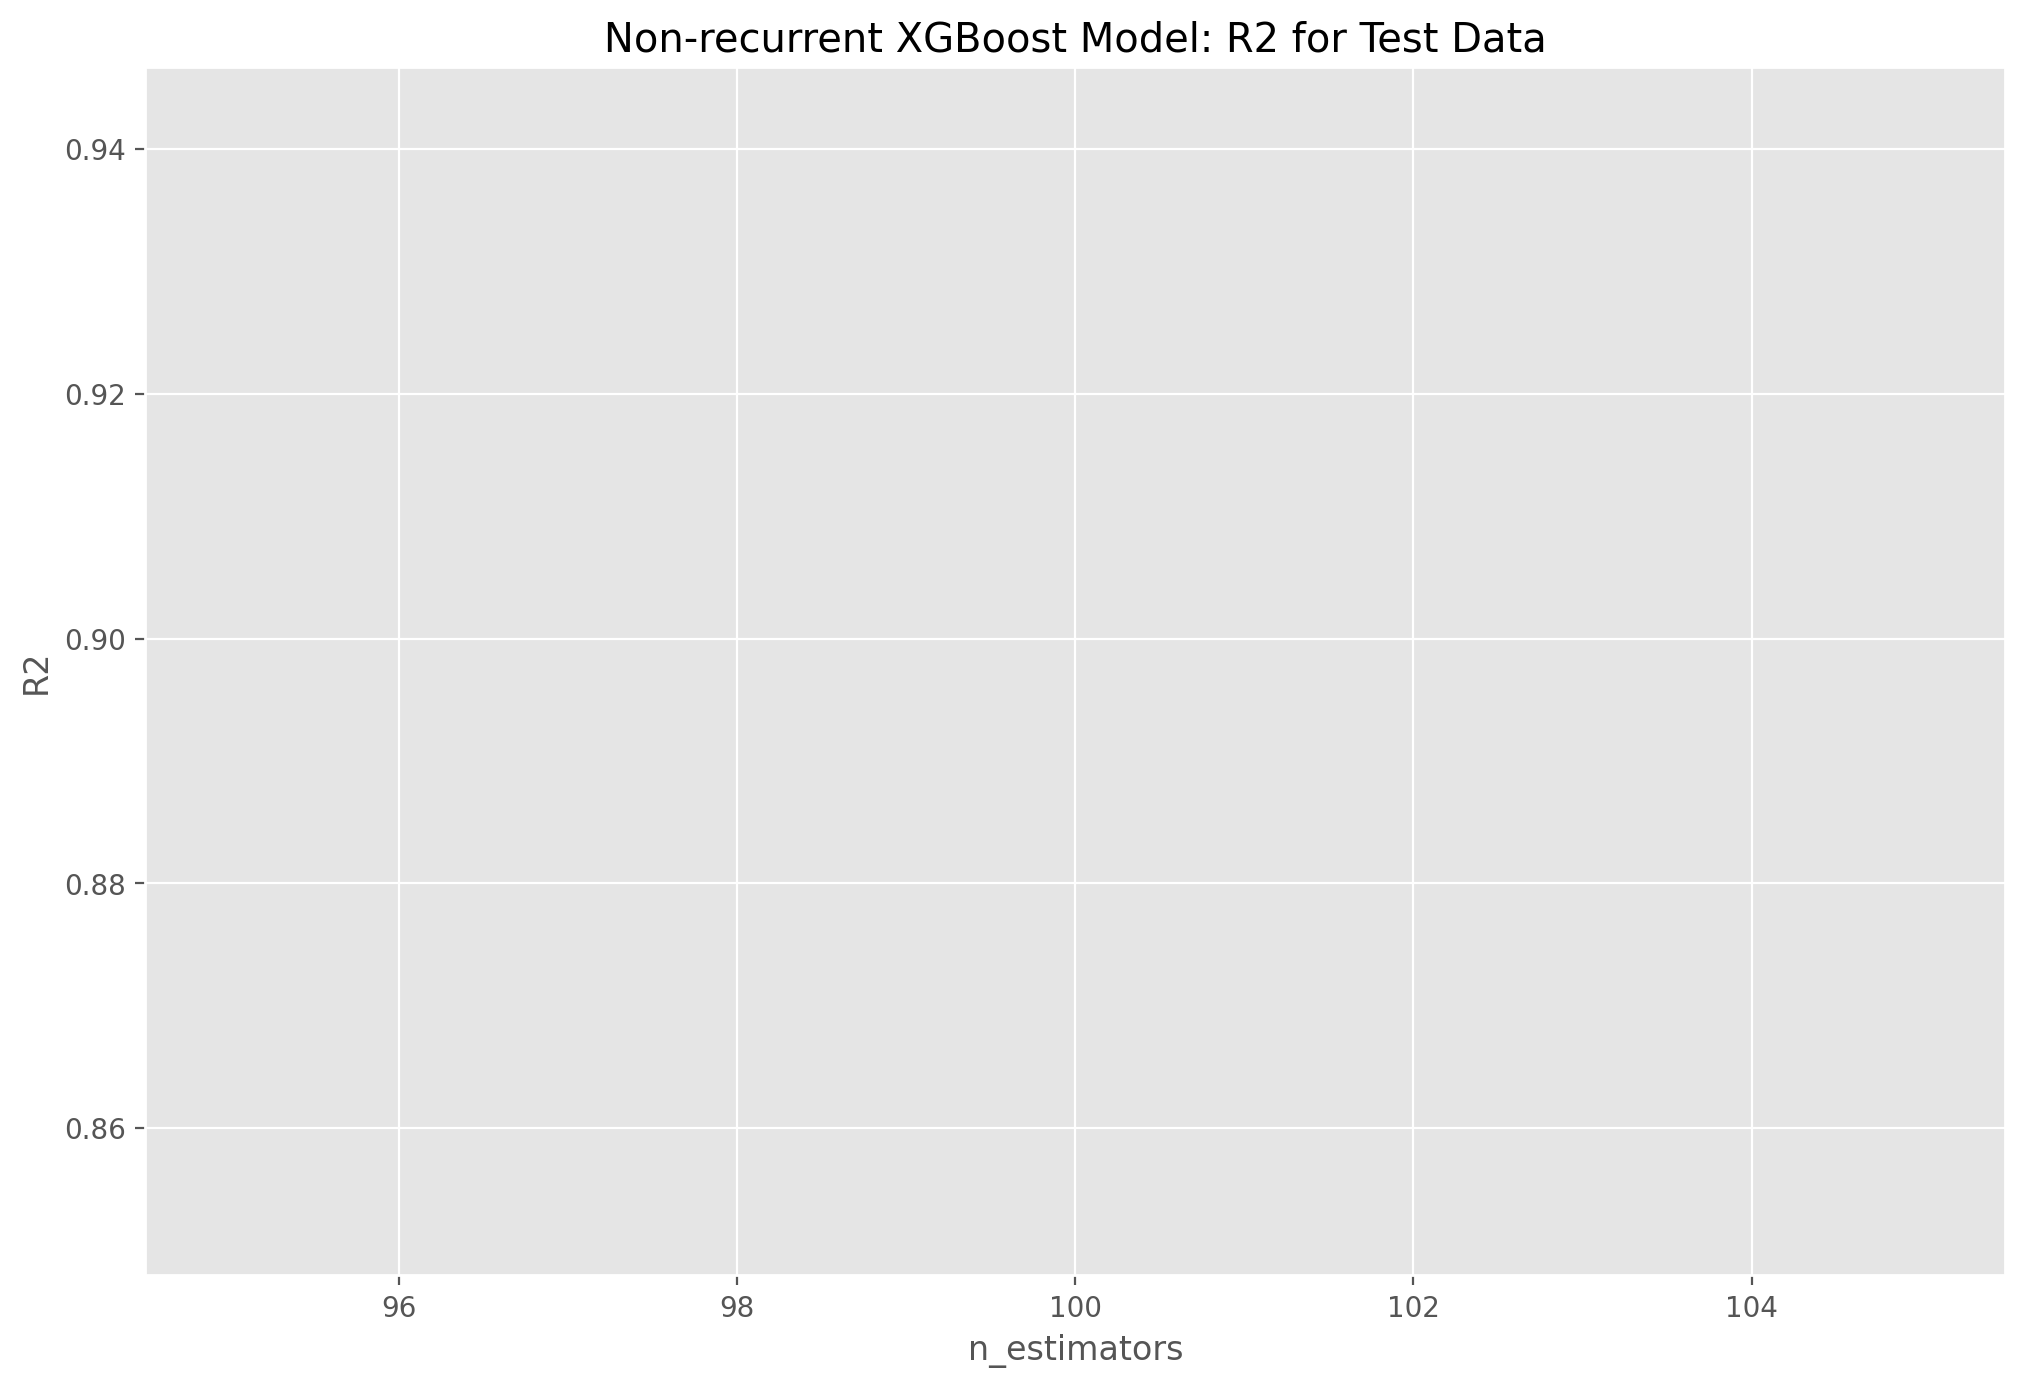

In [55]:
plot_progress_results(r2_history, model_type, is_recurrent, metric="R2")